In [1]:
import sys, os
import argparse
import time
from types import SimpleNamespace


import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import faiss
import skimage.io as io

from dataset import CocoDataset, EmbedDataset
from utils import weight_init, collater, sec2str
from model import ImageEncoder, CaptionEncoder
from vocab import Vocabulary
from eval import retrieve_i2c, retrieve_c2i

In [2]:
path = "models/vsepp"
sorted(os.listdir(path))

['epoch_0001_score_00386.ckpt',
 'epoch_0002_score_00667.ckpt',
 'epoch_0003_score_00822.ckpt',
 'epoch_0004_score_00982.ckpt',
 'epoch_0005_score_01820.ckpt',
 'epoch_0006_score_03207.ckpt',
 'epoch_0007_score_03762.ckpt',
 'epoch_0008_score_04157.ckpt',
 'epoch_0009_score_06317.ckpt',
 'epoch_0010_score_06424.ckpt',
 'epoch_0011_score_08780.ckpt',
 'epoch_0013_score_11608.ckpt',
 'epoch_0014_score_12094.ckpt',
 'epoch_0016_score_13328.ckpt',
 'epoch_0017_score_13757.ckpt',
 'epoch_0018_score_17275.ckpt',
 'epoch_0019_score_17485.ckpt',
 'epoch_0021_score_17819.ckpt',
 'epoch_0022_score_20140.ckpt',
 'epoch_0026_score_26878.ckpt',
 'epoch_0027_score_28631.ckpt',
 'epoch_0028_score_30253.ckpt',
 'epoch_0029_score_30856.ckpt',
 'epoch_0030_score_31629.ckpt',
 'epoch_0031_score_31841.ckpt',
 'epoch_0032_score_32375.ckpt',
 'epoch_0033_score_32725.ckpt',
 'epoch_0034_score_33303.ckpt',
 'epoch_0035_score_34020.ckpt',
 'epoch_0038_score_34784.ckpt',
 'epoch_0039_score_34843.ckpt',
 'epoch_

In [3]:
def get_args():
    a = {
        "dataset": "coco",
        "checkpoint": os.path.join(path, "epoch_0050_score_37752.ckpt"),   # checkpoint from where to load model
        'root_path': '/groups1/gaa50131/datasets/MSCOCO',
        'vocab_path': 'captions_train2017.txt',
        'cnn_type': "resnet152",
        'rnn_type': "GRU",
        'emb_size': 300,
        'out_size': 1024,
        'max_len': 30,
        'n_cpu': 8,
        'imsize': 224, 
        'batch_size': 128
    }
    
    args = SimpleNamespace(**a)
    
    return args

args = get_args()

In [5]:
# transform if dataset is of images
transform = transforms.Compose([
    transforms.Resize((args.imsize, args.imsize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

if args.dataset == 'coco':
    val_dset = CocoDataset(root=args.root_path, imgdir='val2017', jsonfile='annotations/captions_val2017.json', transform=transform)
val_loader = DataLoader(val_dset, batch_size=args.batch_size, shuffle=False, num_workers=args.n_cpu, collate_fn=collater)
vocab = Vocabulary(max_len=args.max_len)
vocab.load_vocab(args.vocab_path)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
building vocabulary...
done building vocabulary, minimum frequency is 5 times
# of words in vocab: 10210 | elapsed: 33s


In [6]:
imenc = ImageEncoder(out_size=args.out_size, cnn_type=args.cnn_type)
capenc = CaptionEncoder(vocab_size=len(vocab), emb_size=args.emb_size, out_size=args.out_size, rnn_type=args.rnn_type, padidx=vocab.padidx)
device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")

assert args.checkpoint is not None
print("loading model checkpoint from {}".format(args.checkpoint))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt = torch.load(args.checkpoint, map_location=device)
imenc.load_state_dict(ckpt["encoder_state"])
capenc.load_state_dict(ckpt["decoder_state"])

begin = time.time()
print("creating database")
dset = EmbedDataset(val_loader, imenc, capenc, vocab, args)
print("database created | {}".format(sec2str(time.time()-begin)))

loading model checkpoint from models/vsepp/epoch_0050_score_37752.ckpt
creating database
[(128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (128, 1024), (8, 1024)]
database created | elapsed: 03m51s


--------------------------------------------------


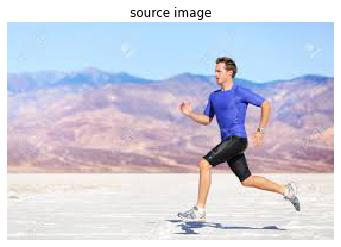

# captions: 25000, dimension: 1024
retrieval time elapsed: 00s
--------------------------------------------------
20 nearest neighbors of image:
Somebody is in the photograph not certain who that individual is. 

A man seems to be disguised as Marty McFly here, from Back to the Future. 
A woman who just caught a frizzebe, and is falling.
a woman leaning over a bit near the end of a court
Individual is doing something at the moment that is intriguing.

Individual is doing something at the moment that is intriguing.
There is no image here to provide a caption for.
There is no image here to provide a caption for.
There is no image here to provide a caption for.
There is no image here to provide a caption for.
There is no image to be reviewed on this hit.
A woman attending an exposition about the future.
A woman walking up to get the freeze bee.
An individual is in the open view in the picture. 

Individual having an astounding time and getting a charge out of some life. 

An individual is

In [20]:
%matplotlib inline
retrieve_i2c(dset, val_dset, "samples/sample1.jpg", imenc, transform, k=20)

--------------------------------------------------
source caption: 'a picture of a tasty-looking noodle soup.'
# images: 5000, dimension: 1024
retrieval time elapsed: 00s
--------------------------------------------------
10 nearest neighbors of 'a picture of a tasty-looking noodle soup.'


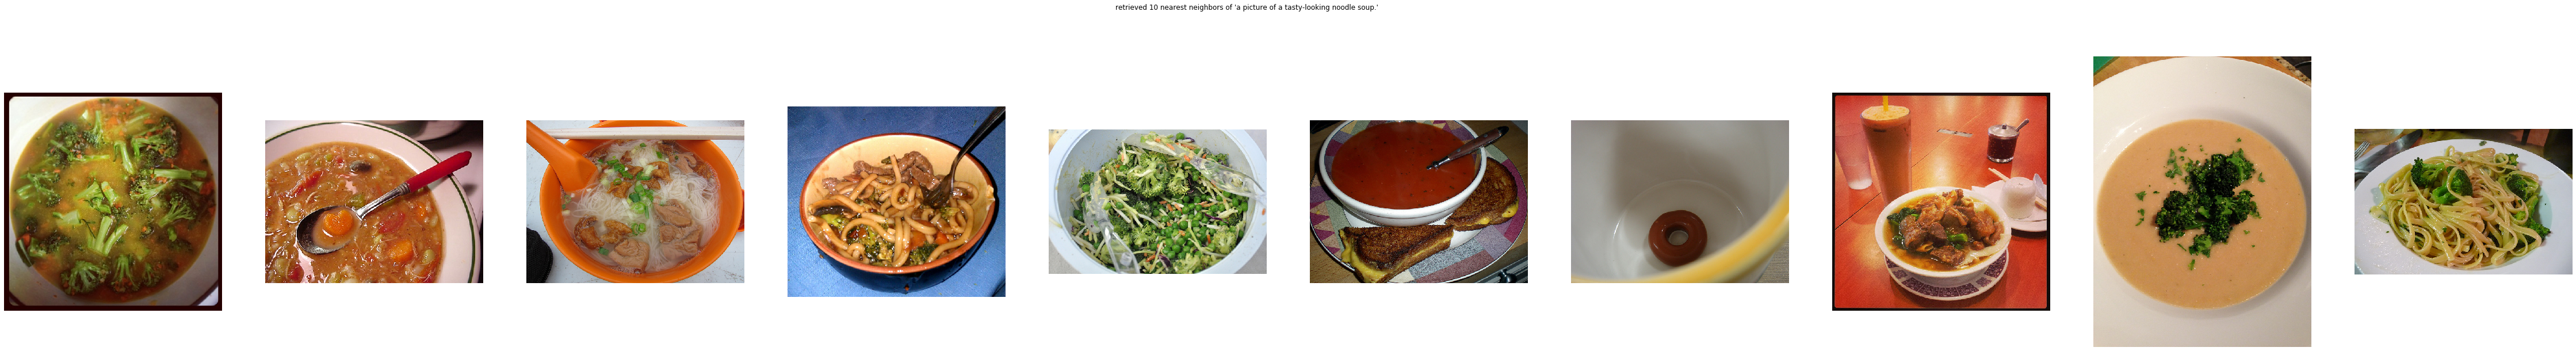

--------------------------------------------------


In [22]:
%matplotlib inline
caption = "a picture of a tasty-looking noodle soup."
retrieve_c2i(dset, val_dset, caption, capenc, vocab, k=10)